In this notebook I will try my DQN model with the all in and out actions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import itertools
import pickle

from sklearn.preprocessing import StandardScaler

In [2]:
#data enriched on jupyter notebook due to talib library has already installed on Anaconda env
df = pd.read_csv('Stocks2.csv')
df

,AAPL,MSI,SBUX,SMA_AAPL,SMA_MSI,SMA_SBUX,EMA_AAPL,EMA_MSI,EMA_SBUX,RSI_AAPL,RSI_MSI,RSI_SBUX
0,67.8542,60.30,28.185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68.5614,60.90,28.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66.8428,60.83,28.130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66.7156,60.81,27.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,66.6556,61.12,27.775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1254,167.7800,99.12,56.000,173.651429,97.798571,59.532857,171.613007,97.501321,58.598744,35.765808,66.187429,29.814509
1255,160.5000,103.87,55.770,172.466429,98.320000,59.202143,170.131272,98.350478,58.221578,24.836304,77.099339,28.861158
1256,156.4900,101.06,54.690,171.059286,98.691429,58.782857,168.312436,98.711748,57.750701,21.025056,63.951090,24.843932
1257,163.0300,102.76,55.610,169.911429,99.082857,58.422143,167.608111,99.251515,57.465274,37.791716,67.555884,33.354041


In [3]:
df=df.bfill()
df

,AAPL,MSI,SBUX,SMA_AAPL,SMA_MSI,SMA_SBUX,EMA_AAPL,EMA_MSI,EMA_SBUX,RSI_AAPL,RSI_MSI,RSI_SBUX
0,67.8542,60.30,28.185,65.306264,61.190714,27.345714,65.306264,61.190714,27.345714,20.813557,61.075544,39.285714
1,68.5614,60.90,28.070,65.306264,61.190714,27.345714,65.306264,61.190714,27.345714,20.813557,61.075544,39.285714
2,66.8428,60.83,28.130,65.306264,61.190714,27.345714,65.306264,61.190714,27.345714,20.813557,61.075544,39.285714
3,66.7156,60.81,27.915,65.306264,61.190714,27.345714,65.306264,61.190714,27.345714,20.813557,61.075544,39.285714
4,66.6556,61.12,27.775,65.306264,61.190714,27.345714,65.306264,61.190714,27.345714,20.813557,61.075544,39.285714
...,...,...,...,...,...,...,...,...,...,...,...,...
1254,167.7800,99.12,56.000,173.651429,97.798571,59.532857,171.613007,97.501321,58.598744,35.765808,66.187429,29.814509
1255,160.5000,103.87,55.770,172.466429,98.320000,59.202143,170.131272,98.350478,58.221578,24.836304,77.099339,28.861158
1256,156.4900,101.06,54.690,171.059286,98.691429,58.782857,168.312436,98.711748,57.750701,21.025056,63.951090,24.843932
1257,163.0300,102.76,55.610,169.911429,99.082857,58.422143,167.608111,99.251515,57.465274,37.791716,67.555884,33.354041


In [5]:
#ENV for multi stocks
class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
        - # shares of stock 1 owned
        - # shares of stock 2 owned
        - # shares of stock 3 owned
        - price of stock 1 (using daily close price)
        - price of stock 2
        - price of stock 3
        - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
        - for each stock, you can:
        - 0 = sell ½
        - 1 = hold
        - 2 = buy ½
        - 3
    """
    def __init__(self, data, initial_investment=20000):
        # data

        self.stock_price_history = data.iloc[:,0:3].values #Taking price data to price history
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.state_dim = 2*self.n_stock+1

        self.action_space = np.arange(3**self.n_stock)


        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # .....
        # 0 = sell ½
        # 1 = hold
        # 2 = buy ½
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        #self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs

    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
            # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            # NOTE: when buying, we will loop through each stock we want to buy,
            #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False


In [6]:
#It is for raplay
#I store agent's experience on replay buffer
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])



In [7]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states after fitting the scaler with some random actions
    states = []
    #play game 100 times with random actions to collect some states
    for i in range(100):
        for j in range(env.n_step):
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
            if done:
                env.reset()
                break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


In [8]:
#DQN model with 2 hidden layer
def DQN(input_dim, n_action, n_hidden_layers=2, hidden_dim=[16,16]):
  #I created DQN
    i = Input(shape=(input_dim,))
    x = i
    for a in range(n_hidden_layers):
        x = Dense(hidden_dim[a], activation='relu')(x)

    x = Dense(n_action)(x)
    model = Model(i, x)

    model.compile(loss='mse', optimizer='adam')
    print((model.summary()))
    return model

In [9]:
#Class for agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=500)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)

    def update_replay_memory(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def replay(self, batch_size=32):
        #first check if replay buffer contains enough data
        if self.memory.size < batch_size:
            return

        # sample a batch of data from the replay memory
        minibatch = self.memory.sample_batch(batch_size)
        states = minibatch['s']
        actions = minibatch['a']
        rewards = minibatch['r']
        next_states = minibatch['s2']
        done = minibatch['d']

        #Calculation the tentative target: Q(s',a)
        target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)


        target_full = self.model.predict(states)
        target_full[np.arange(batch_size), actions] = target

        self.model.train_on_batch(states, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [10]:
def play_one_episode(agent, env, is_train, scaler):
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(32)
    state = next_state

  return info['cur_val']

In [11]:
train_portfolio_value_a = []

num_episodes = 2000

data=df
n_timestamp, n_stocks = data.shape
n_train = n_timestamp // 2
is_train=True
train_data = data[:n_train]

env = MultiStockEnv(data=train_data)
env.reset()
state_size = env.state_dim
action_size = len(env.action_space)

scaler = get_scaler(env)

agent = DQNAgent(state_size, action_size)

for i in range(num_episodes):
    val = play_one_episode(agent, env,is_train, scaler)
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    train_portfolio_value_a.append(val)





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 27)                459       
                                                                 
Total params: 859 (3.36 KB)
Trainable params: 859 (3.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
episode: 1/2000, episode end value: 19956.44
episode: 2/2000, episode end value: 29667.59
episode: 3/2000, episode end value: 24642.83
episode: 4/2000, episod

(array([ 45., 182., 461., 530., 378., 231., 108.,  43.,  18.,   4.]),
 array([14261.6491    , 18166.75454   , 22071.85998   , 25976.96542   ,
        29882.07086   , 33787.1763    , 37692.28174   , 41597.38718   ,
        45502.49262001, 49407.59806001, 53312.70350001]),
 <BarContainer object of 10 artists>)

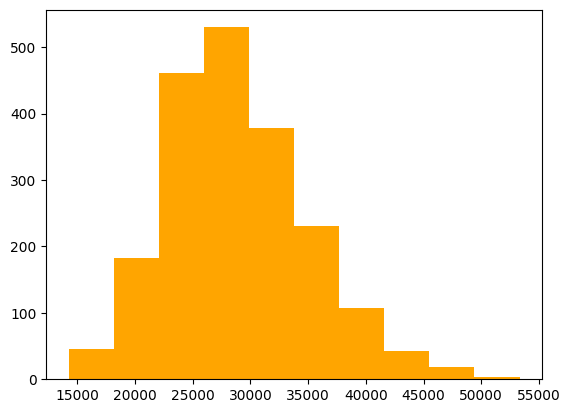

In [12]:
plt.hist(train_portfolio_value_a, color="orange")

In [13]:
np.mean(train_portfolio_value_a)

28871.392765450128

In [14]:
# store the final value of the portfolio (end of episode)
test_portfolio_value_a = []

num_episodes = 2000

is_train=False
data=df
n_timestamp, n_stocks = data.shape
n_train = n_timestamp // 2

test_data = data[n_train:]

env = MultiStockEnv(data=test_data)
env.reset()
state_size = env.state_dim
action_size = len(env.action_space)

scaler = get_scaler(env)

agent = DQNAgent(state_size, action_size)

# play the game num_episodes times
for i in range(num_episodes):
    val = play_one_episode(agent, env, is_train, scaler)
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    test_portfolio_value_a.append(val) # append episode end portfolio value





Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 27)                459       
                                                                 
Total params: 859 (3.36 KB)
Trainable params: 859 (3.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
episode: 1/2000, episode end value: 25436.89
episode: 2/2000, episode end value: 27487.17
episode: 3/2000, episode end value: 48920.20
episode: 4/2000, epis

(array([ 43., 268., 583., 540., 339., 143.,  55.,  20.,   5.,   4.]),
 array([12266.775 , 16305.9325, 20345.09  , 24384.2475, 28423.405 ,
        32462.5625, 36501.72  , 40540.8775, 44580.035 , 48619.1925,
        52658.35  ]),
 <BarContainer object of 10 artists>)

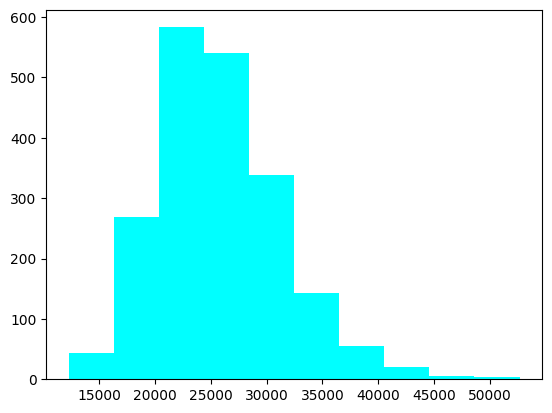

In [15]:
plt.hist(test_portfolio_value_a, color="cyan")


In [16]:
np.mean(test_portfolio_value_a)

25746.02485749967

In [17]:
class DQN_random_ustad:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=500)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)

    def update_replay_memory(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def replay(self, batch_size=64):
        # first check if replay buffer contains enough data
        if self.memory.size < batch_size:
            return

        # sample a batch of data from the replay memory
        minibatch = self.memory.sample_batch(batch_size)
        states = minibatch['s']
        actions = minibatch['a']
        rewards = minibatch['r']
        next_states = minibatch['s2']
        done = minibatch['d']

        #Calculation the tentative target: Q(s',a)
        target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)


        target_full = self.model.predict(states)
        target_full[np.arange(batch_size), actions] = target

        self.model.train_on_batch(states, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon = 1.0



In [18]:
ustad_portfolio_value_a = []

num_episodes = 2000
is_train=True
data=df
n_timestamp, n_stocks = data.shape
n_train = n_timestamp // 2



env = MultiStockEnv(data=train_data)
env.reset()
state_size = env.state_dim
action_size = len(env.action_space)

scaler = get_scaler(env)

agent = DQN_random_ustad(state_size, action_size)

# play the game num_episodes times
for i in range(num_episodes):
    val = play_one_episode(agent, env, is_train, scaler)
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    ustad_portfolio_value_a.append(val) # append episode end portfolio value





Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_6 (Dense)             (None, 16)                128       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 27)                459       
                                                                 
Total params: 859 (3.36 KB)
Trainable params: 859 (3.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
episode: 1/2000, episode end value: 40344.11
episode: 2/2000, episode end value: 23724.48
episode: 3/2000, episode end value: 33389.92
episode: 4/2000, epis

(array([ 81., 368., 665., 500., 243., 101.,  29.,   6.,   6.,   1.]),
 array([14555.7648 , 19375.67952, 24195.59424, 29015.50896, 33835.42368,
        38655.3384 , 43475.25312, 48295.16784, 53115.08256, 57934.99728,
        62754.912  ]),
 <BarContainer object of 10 artists>)

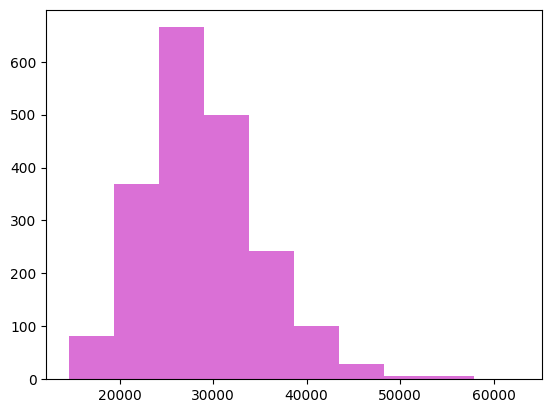

In [19]:
plt.hist(ustad_portfolio_value_a, color="orchid")


In [20]:
np.mean(ustad_portfolio_value_a)

28912.23469620013

In [21]:
ustad_portfolio_value_test_a = []

num_episodes = 2000

is_train=False
data=df
n_timestamp, n_stocks = data.shape
n_train = n_timestamp // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(data=test_data)
env.reset()
state_size = env.state_dim
action_size = len(env.action_space)

scaler = get_scaler(env)

agent = DQN_random_ustad(state_size, action_size)

# play the game num_episodes times
for i in range(num_episodes):
    val = play_one_episode(agent, env, is_train, scaler)
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    ustad_portfolio_value_test_a.append(val) # append episode end portfolio value





Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_9 (Dense)             (None, 16)                128       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 27)                459       
                                                                 
Total params: 859 (3.36 KB)
Trainable params: 859 (3.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
episode: 1/2000, episode end value: 26981.61
episode: 2/2000, episode end value: 21034.55
episode: 3/2000, episode end value: 27165.04
episode: 4/2000, epis

(array([ 22., 219., 527., 536., 400., 167.,  88.,  30.,   5.,   6.]),
 array([12365.22  , 16049.2605, 19733.301 , 23417.3415, 27101.382 ,
        30785.4225, 34469.463 , 38153.5035, 41837.544 , 45521.5845,
        49205.625 ]),
 <BarContainer object of 10 artists>)

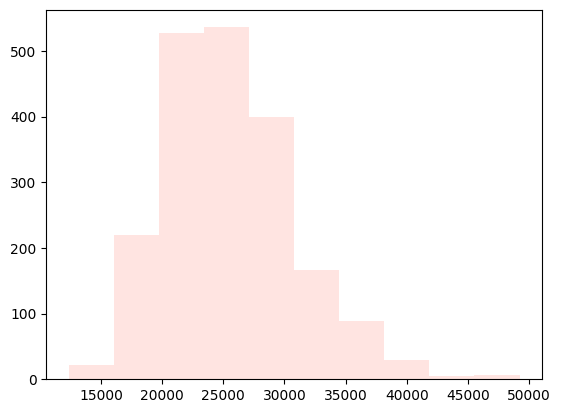

In [22]:
plt.hist(ustad_portfolio_value_test_a, color="mistyrose")


In [23]:
np.mean(ustad_portfolio_value_test_a)

25498.475729999667

In [24]:
np.savez("TraderPortfolios_all_in_out.npz", TrainingPortfolio=train_portfolio_value_a,
         TestPortfolio=test_portfolio_value_a,
         TrainUstadPortfolio=ustad_portfolio_value_a,
         TestUstadPortfolio=ustad_portfolio_value_test_a)